#Dependencies#

In [ ]:
#Install Dependencies
!pip install transformers --quiet
!pip install datasets transformers[SentencePiece] --quiet
!pip install pyter3 --quiet
!pip install torchmetrics --quiet

In [1]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'CS685-Project/s2s-decipherment-multilingual'
%cd /content/drive/My\Drive/$FOLDERNAME/code

Mounted at /content/drive
/content/drive/MyDrive/CS685-Project/s2s-decipherment-multilingual/code


In [ ]:
#Set path of python code modules
import sys
sys.path.append('/content/drive/My Drive/{}/code'.format(FOLDERNAME))

%load_ext autoreload
%autoreload 2

In [ ]:
#Import Dependencies
from datasets import DatasetDict
from transformers import AutoTokenizer, AutoModel, AdamW, DataCollatorWithPadding, get_scheduler, logging
import pandas as pd
import torch
from torch import Tensor
from torch.optim import *
import torch.optim
from torch.utils.data import DataLoader
from torch.nn import *
from torch.nn.functional import one_hot as get_one_hot_enc
from torch.nn.functional import cross_entropy
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer, Embedding, TransformerDecoderLayer, TransformerDecoder, Transformer
from tqdm.auto import tqdm
import numpy as np
from os import listdir
from os.path import isfile, join
import math
from lxml.html import fromstring
import lxml.html as PARSER
import string
import random
from collections import Counter
from models import Deciphormer
from data_utils import create_master_data, get_split_dfs, get_idx_to_chr, get_chr_to_idx
from data import CipherDataset
from train_test import validation_loop, fit
import copy
import time
import matplotlib.pyplot as plt
from pyter import ter
from torchmetrics import WER

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
device

device(type='cuda')

#Create Master Data #

In [ ]:
#1. Read all individual language files from the data/ folder
#2. Create test and train data frames and write to .csv files in master_data/ folder
#3. It creates different files based on the cipher length and space encoding schemes

#Note: Run this only if the file for the particular experiment doesn't exist already in the master_data folder

#Experiment setup options
space_encs = ['with_space', 'enc_space','removed_spaces'] #Different space encoding schemes
cip_lens = [32, 256] #Different Cipher Lengths. We used 32 and 256, but any value in the [1,256] range can be used
tasks = ['single','multi'] #'single' stands for the baseline. 'multi' is our multi-task model with language loss

#Choose specific options
space_enc = space_encs[0] #Choose specific space scheme for this experiment
cip_len = cip_lens[0] #Choose cipher length
task = tasks[0] # Choose task

#Can run this for loop to create all possible data combos, but takes a long time
#./code/data_utils.py contains the create_master_data() function called here
for space_enc in space_encs:
  for cip_len in cip_lens:
    df,df_test = create_master_data('/content/drive/My Drive/{}/data'.format(FOLDERNAME), task, cip_len, space_enc)
    df_train, df_val = get_split_dfs(df=df)

#We only need 50 samples for the test set
df_test = df_test[:50]

Loading catalan.dev ...
Loading catalan.test ...
Loading danish.dev ...
Loading catalan.train ...
Loading danish.test ...
Loading danish.train ...
Loading dutch.dev ...
Loading dutch.test ...
Loading dutch.train ...
Loading finnish.dev ...
Loading finnish.test ...
Loading finnish.train ...
Loading french.test ...
Loading french.dev ...
Loading french.train ...
Loading german.test ...
Loading german.dev ...
Loading hungarian.test ...
Loading hungarian.dev ...
Loading german.train ...
Loading hungarian.train ...
Loading italian.dev ...
Loading italian.test ...
Loading latin.dev ...
Loading italian.train ...
Loading latin.test ...
Loading norwegian.dev ...
Loading latin.train ...
Loading norwegian.train ...
Loading norwegian.test ...
Loading portuguese.test ...
Loading portuguese.dev ...
Loading portuguese.train ...
Loading spanish.test ...
Loading spanish.dev ...
Loading swedish.test ...
Loading spanish.train ...
Loading swedish.dev ...
Loading swedish.train ...
Loading english.dev ...
L

#Experiment#


In [ ]:
#Sanity check the size of train, val, and test data.
print(len(df_train))
print(len(df_val))
print(len(df_test))

1605
33
50


In [ ]:
#Note: Run this cell when the file for the experiment is already present in ./master_data, so you can save on loading time

#Run this only if master data exists for this experiment
df_train, df_val = get_split_dfs('/content/drive/My Drive/{}/master_data/{}_{}_{}.csv'.format(FOLDERNAME,'train', cip_len,space_enc))
df_test = pd.read_csv('/content/drive/My Drive/{}/master_data/{}_{}_{}.csv'.format(FOLDERNAME,'test', cip_len,space_enc), nrows=50)


In [ ]:
#Create Train, Test, and Val Dataloaders from DataFrames.
#For the implementation of the CipherDataset check ./code/data.py
batch_size=16
train_dataset = CipherDataset(df_train)
val_dataset = CipherDataset(df_val)
test_dataset = CipherDataset(df_test)
raw_datasets = DatasetDict({'train':train_dataset, 'validation':val_dataset, 'test':test_dataset})

train_dataloader = DataLoader(raw_datasets['train'], batch_size=batch_size)
val_dataloader = DataLoader(raw_datasets['validation'], batch_size=batch_size)
test_dataloader = DataLoader(raw_datasets['test'], batch_size=batch_size)

  0%|          | 0/101 [00:00<?, ?it/s]

Training and validating model
------------------------- Epoch 1 -------------------------
Iteration 1/101: | Train Loss = 3.82 | Val Loss = 2.52 | SER = 1.00


,text,pred
0,a m i c i <EOS>,
1,e s c r o f u l o s o s <EOS>,
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,



Iteration 5/101: | Train Loss = 3.61 | Val Loss = 1.65 | SER = 1.00


,text,pred
0,a m i c i <EOS>,
1,e s c r o f u l o s o s <EOS>,
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,



Iteration 10/101: | Train Loss = 2.78 | Val Loss = 1.40 | SER = 1.00


,text,pred
0,a m i c i <EOS>,
1,e s c r o f u l o s o s <EOS>,
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,



Iteration 15/101: | Train Loss = 2.40 | Val Loss = 1.32 | SER = 1.00


,text,pred
0,a m i c i <EOS>,
1,e s c r o f u l o s o s <EOS>,
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,



Iteration 20/101: | Train Loss = 2.31 | Val Loss = 1.26 | SER = 1.00


,text,pred
0,a m i c i <EOS>,
1,e s c r o f u l o s o s <EOS>,
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,



Iteration 25/101: | Train Loss = 1.75 | Val Loss = 1.23 | SER = 1.00


,text,pred
0,a m i c i <EOS>,
1,e s c r o f u l o s o s <EOS>,
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,



Iteration 30/101: | Train Loss = 2.21 | Val Loss = 1.21 | SER = 1.00


,text,pred
0,a m i c i <EOS>,
1,e s c r o f u l o s o s <EOS>,
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,



Iteration 35/101: | Train Loss = 1.85 | Val Loss = 1.19 | SER = 1.00


,text,pred
0,a m i c i <EOS>,
1,e s c r o f u l o s o s <EOS>,
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,



Iteration 40/101: | Train Loss = 1.58 | Val Loss = 1.16 | SER = 1.00


,text,pred
0,a m i c i <EOS>,
1,e s c r o f u l o s o s <EOS>,
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,



Iteration 45/101: | Train Loss = 1.43 | Val Loss = 0.97 | SER = 1.00


,text,pred
0,a m i c i <EOS>,
1,e s c r o f u l o s o s <EOS>,
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,



Iteration 50/101: | Train Loss = 1.27 | Val Loss = 0.78 | SER = 0.71


,text,pred
0,a m i c i <EOS>,a _ _ _ _
1,e s c r o f u l o s o s <EOS>,_ _ _ _ _ _ _ _ _
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,_ _ e _ e _ _ _ _ e _ _ _ _ _ _ _
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,_ _ e _ _ _ _ _ _ _ e _ _ e _ _ _
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,e _ _ e _ _ e _ _ _ _ _ _ _ _ e _ e _ e _...



Iteration 55/101: | Train Loss = 1.19 | Val Loss = 0.60 | SER = 0.20


,text,pred
0,a m i c i <EOS>,a a i a i _
1,e s c r o f u l o s o s <EOS>,_ r o _ _ l o s o s _
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,l _ i _ e r d e _ e o r _ e n s _ _ r _ _
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,_ _ a _ e n _ a _ u i _ s e s _ e r a _
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,e a _ e t e n d e n _ d i o n _ e _ i e s e...



Iteration 60/101: | Train Loss = 0.91 | Val Loss = 0.45 | SER = 0.02


,text,pred
0,a m i c i <EOS>,a m i c i <EOS>
1,e s c r o f u l o s o s <EOS>,e s c r o f u l o s o s <EOS>
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,i l _ i _ i e r d e _ m o r g e n s _ g r y <...
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,n o c _ a v e n c a _ q u i _ s e s p e r a <EOS>
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,e o b a c h t e n d e n _ d i o n _ b e w i e ...



Iteration 65/101: | Train Loss = 0.69 | Val Loss = 0.36 | SER = 0.00


,text,pred
0,a m i c i <EOS>,a m i c i <EOS>
1,e s c r o f u l o s o s <EOS>,e s c r o f u l o s o s <EOS>
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,t i l _ i _ j e r d e _ m o r g e n s _ g r y...
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,b e o b a c h t e n d e n _ d i o n _ b e w i ...



Iteration 70/101: | Train Loss = 0.60 | Val Loss = 0.28 | SER = 0.00


,text,pred
0,a m i c i <EOS>,a m i c i <EOS>
1,e s c r o f u l o s o s <EOS>,e s c r o f u l o s o s <EOS>
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,b e o b a c h t e n d e n _ d i o n _ b e w i ...



Iteration 75/101: | Train Loss = 0.58 | Val Loss = 0.23 | SER = 0.00


,text,pred
0,a m i c i <EOS>,a m i c i <EOS>
1,e s c r o f u l o s o s <EOS>,e s c r o f u l o s o s <EOS>
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,b e o b a c h t e n d e n _ d i o n _ b e w i ...



Iteration 80/101: | Train Loss = 0.68 | Val Loss = 0.19 | SER = 0.00


,text,pred
0,a m i c i <EOS>,a m i c i <EOS>
1,e s c r o f u l o s o s <EOS>,e s c r o f u l o s o s <EOS>
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,b e o b a c h t e n d e n _ d i o n _ b e w i ...



Iteration 85/101: | Train Loss = 0.50 | Val Loss = 0.16 | SER = 0.00


,text,pred
0,a m i c i <EOS>,a m i c i <EOS>
1,e s c r o f u l o s o s <EOS>,e s c r o f u l o s o s <EOS>
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,b e o b a c h t e n d e n _ d i o n _ b e w i ...



Iteration 90/101: | Train Loss = 0.63 | Val Loss = 0.14 | SER = 0.00


,text,pred
0,a m i c i <EOS>,a m i c i <EOS>
1,e s c r o f u l o s o s <EOS>,e s c r o f u l o s o s <EOS>
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,b e o b a c h t e n d e n _ d i o n _ b e w i ...



Iteration 95/101: | Train Loss = 0.47 | Val Loss = 0.12 | SER = 0.00


,text,pred
0,a m i c i <EOS>,a m i c i <EOS>
1,e s c r o f u l o s o s <EOS>,e s c r o f u l o s o s <EOS>
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,b e o b a c h t e n d e n _ d i o n _ b e w i ...



Iteration 100/101: | Train Loss = 0.41 | Val Loss = 0.10 | SER = 0.00


,text,pred
0,a m i c i <EOS>,a m i c i <EOS>
1,e s c r o f u l o s o s <EOS>,e s c r o f u l o s o s <EOS>
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,b e o b a c h t e n d e n _ d i o n _ b e w i ...



Iteration 101/101: | Train Loss = 0.44 | Val Loss = 0.10 | SER = 0.00


,text,pred
0,a m i c i <EOS>,a m i c i <EOS>
1,e s c r o f u l o s o s <EOS>,e s c r o f u l o s o s <EOS>
2,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...,t i l _ i _ f j e r d e _ m o r g e n s _ g r ...
3,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>,p o c _ a v e n c a _ q u i _ s e s p e r a <EOS>
4,b e o b a c h t e n d e n _ d i o n _ b e w i ...,b e o b a c h t e n d e n _ d i o n _ b e w i ...


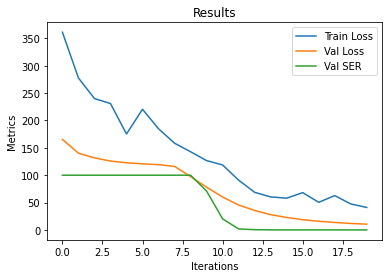

In [ ]:
#Define some hyperparams for training
epochs = 1
lr = 1e-4
chr_to_idx = get_chr_to_idx()
idx_to_chr = get_idx_to_chr()

#Train Model
np.random.seed(0)

#Initialize a model, optimizer, and loss function for this particular experiment.
#./code/models.py contains the implementation of this function 
model = Deciphormer(ntoken=len(get_chr_to_idx()), max_len= cip_len, task = task, space_enc=space_enc)
optimizer = Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()
model.to(device)

#Call training loop and get list of train loss, val loss, SERs, and the best_model
train_loss_list, validation_loss_list, SER_list, best_model = fit(model, optimizer, loss_fn, train_dataloader, val_dataloader, epochs = epochs)

#plot results from loss and SER lists
train_loss_list = np.array(train_loss_list)*100
validation_loss_list = np.array(validation_loss_list)*100
SER_list = np.array(SER_list)*100
x = list(range(len(train_loss_list)))
plt.xlabel("Iterations")
plt.ylabel("Metrics")
plt.title("Results")
plt.plot(x,train_loss_list, label = 'Train Loss')
plt.plot(x, validation_loss_list,label = 'Val Loss')
plt.plot(x, SER_list,label = 'Val SER')
plt.legend()
plt.show()

#OUTPUT
#1. Every 't' iterations, we print loss and SER
#2. We also print 5 predictions to see how the quality improves over time
#3. We plot the training loss and SER graph at the end

In [ ]:
#During training, we saved the best model's state_dict() to a file in ./output/xyz.pth
#We now load this state_dict() and use it to evaluate on the test set of 50 ciphers
best_model = 'saved_model_{}_{}_{}'.format(model.task, model.seq_len-1, model.space_enc)
checkpoint = torch.load('/content/drive/My Drive/{}/output/{}.pth'.format(FOLDERNAME,best_model))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

#Define experiment name to save the output to ./output/xyz.csv
experiment = '{}_{}_{}'.format(model.task, model.seq_len-1, model.space_enc)

loss_fn = torch.nn.CrossEntropyLoss()

_, SER, pred, _ = validation_loop(model, loss_fn, test_dataloader)
test_sample = df_test.copy()
test_sample['pred'] = pred
print("Experiment: {} | SER/TER: {}".format(experiment,SER))

#Display the test examples
display(test_sample)
test_sample.to_csv('/content/drive/My Drive/{}/output/predictions_{}.csv'.format(FOLDERNAME, experiment))

Experiment: multi_256_removed_spaces | SER/TER: 0.0


,text,input_ids,labels,lang,pred
0,s u a _ a r d e n t e _ m o c i d a d e _ t r ...,28 2 10 1 1 3 4 0 5 6 0 11 7 8 9 4 1 4 0 6 3 1...,28 18 20 0 26 0 17 3 4 13 19 4 26 12 14 2 8 3 ...,13,s u a _ a r d e n t e _ m o c i d a d e _ t r ...
1,a n n u n c i a d a _ c o n t i g u a _ a o _ ...,28 1 2 2 5 2 6 3 1 4 1 6 0 2 9 3 12 5 1 1 0 13...,28 0 13 13 20 13 2 8 0 3 0 26 2 14 13 19 8 6 2...,13,a n n u n c i a d a _ c o n t i g u a _ a o _ ...
2,a i u t a r n e _ l a _ r i u s c i t a _ a v ...,28 0 3 2 6 0 4 5 1 7 0 4 3 2 11 10 3 6 0 0 8 1...,28 0 8 20 19 0 17 13 4 26 11 0 26 17 8 20 18 2...,12,a i u t a r n e _ l a _ r i u s c i t a _ a v ...
3,h a n _ k u n d e _ i n g e n t i n g _ s a g ...,28 9 0 1 12 13 1 3 4 5 1 2 4 1 10 5 1 2 14 0 2...,28 7 0 13 26 10 20 13 3 4 26 8 13 6 4 13 19 8 ...,9,h a n _ k u n d e _ i n g e n t i n g _ s a g ...
4,m e n _ j e g _ v a r _ i k k e _ s a a _ l e ...,28 12 0 10 11 0 2 3 1 4 5 6 6 0 13 1 1 7 0 8 1...,28 12 4 13 26 9 4 6 26 21 0 17 26 8 10 10 4 26...,5,m e n _ j e g _ v a r _ i k k e _ s a a _ l e ...
5,n a d e e l _ z i j _ m o c h t _ g e e n _ m ...,28 1 2 8 0 0 9 12 13 14 5 3 15 4 6 7 0 0 1 5 2...,28 13 0 3 4 4 11 26 25 8 9 26 12 14 2 7 19 26 ...,10,n a d e e l _ z i j _ m o c h t _ g e e n _ m ...
6,t h e _ b e s t _ p e r f o r m e r _ b y _ f ...,28 1 8 0 5 0 3 1 9 0 2 6 4 2 10 0 2 5 14 6 11 ...,28 19 7 4 26 1 4 18 19 26 15 4 17 5 14 17 12 4...,1,t h e _ b e s t _ p e r f o r m e r _ b y _ f ...
7,h j e l p a _ h e n n e,28 1 3 0 4 5 6 1 0 2 2 0 29 27 27 27 27 27 27 ...,28 7 9 4 11 15 0 26 7 4 13 13 4 29 27 27 27 27...,9,h j e l p a _ h e n n e <EOS>
8,d e i r a s _ f u m a n d o _ a _ n o i t e _...,28 2 3 1 6 0 7 8 9 10 0 4 2 5 0 4 5 1 11 3 1 0...,28 3 4 8 17 0 18 26 5 20 12 0 13 3 14 26 0 26 ...,13,d e i r a s _ f u m a n d o _ a _ n o i t e _ ...
9,t e _ a p a r e c a _ h a v i a m o s _ d e _ ...,28 5 2 0 8 0 9 2 10 0 11 0 6 3 0 7 4 1 12 2 6 ...,28 19 4 26 0 15 0 17 4 2 0 26 7 0 21 8 0 12 14...,13,t e _ a p a r e c a _ h a v i a m o s _ d e _ ...
